# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Cutout transformation

In [2]:
# Custom cutout augmentation
class Cutout(object):
    """
    Randomly masks out one or more patches from an image.
    """

    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.0

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask

        return img


# 1. Read dataset and create dataloaders: 5%

In [3]:
# Dataset augmentation transformation
transform_augmented = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=16),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Validation and testing dataset transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Create dataloaders
batch_size = 64
# Training data
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_augmented
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
# Testing data
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)


Files already downloaded and verified
Files already downloaded and verified


# 2. Create the model: 40%

In [4]:
class Block(nn.Module):
    """
    A block within the Backbone.

    Consists of:
        SpatialAveragePool.
        Linear layer.
        K Conv layers.
    """

    def __init__(self, in_channels, out_channels, num_convs, kernel_size=3):
        super(Block, self).__init__()
        # SpatialAveragePool to vector of d channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Linear layer transforming pooled output to a vector with K elements
        self.fc = nn.Linear(in_channels, num_convs)
        # K Conv layers
        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels, out_channels, kernel_size, padding=kernel_size // 2
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                )
                for _ in range(num_convs)
            ]
        )

    def forward(self, x):
        # Calculating weight vector a = [a1, ..., ak] with g
        weight_vector = F.softmax(self.fc(self.avg_pool(x).squeeze()), dim=-1)
        conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=2)
        # Combining Conv layer outputs with calculated weights a to produce a single output O.
        weighted_output = torch.sum(
            conv_outputs * weight_vector.unsqueeze(1).unsqueeze(-1).unsqueeze(-1), dim=2
        )
        return weighted_output


class Backbone(nn.Module):
    """
    Consists of N Blocks, each with a certain number of convolutional layers.
    """

    def __init__(
        self, num_blocks, num_convs, in_channels=3, out_channels_sequence=[32, 64, 128]
    ):
        super(Backbone, self).__init__()
        self.features = nn.Sequential()

        # Constructing Blocks and Pooling layers
        for i, num_block in enumerate(num_blocks):
            for j in range(num_block):
                self.features.add_module(
                    f"block_{i}_{j}",
                    Block(in_channels, out_channels_sequence[i], num_convs),
                )
                in_channels = out_channels_sequence[i]
            self.features.add_module(f"pool_{i}", nn.MaxPool2d(kernel_size=2, stride=2))

    def forward(self, x):
        return self.features(x)


class Classifier(nn.Module):
    """
    Calculates the mean feature vector ƒ by applying SpatialAveragePool to the Backbone's output. Then passes ƒ through a MLP classifier.
    """

    def __init__(self, in_features, num_classes):
        super(Classifier, self).__init__()
        # Computes a mean feature vector ƒ by applying SpatialAveragePool to the Backbone's output.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        hidden_features = in_features * 2

        # MLP classifier
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class Model(nn.Module):
    """
    Architecture based on Convolutional Neural Networks that uses a Backbone and a Classifier.
    """

    def __init__(self, num_classes, num_blocks=[2, 2, 2], num_convs=3):
        super(Model, self).__init__()
        out_channels_sequence = [32, 64, 128]

        # Backbone
        self.backbone = Backbone(
            num_blocks,
            num_convs,
            in_channels=3,
            out_channels_sequence=out_channels_sequence,
        )

        # Classifier
        final_in_channels = out_channels_sequence[-1]
        self.classifier = Classifier(final_in_channels, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        # Process the output of the last Block in the Backbone through Classifier
        x = self.classifier(x)
        return x

# Use GPU
device = torch.device("cuda:0")

# Initialize model
num_classes = 20
net = Model(num_classes=num_classes).to(device)


# 3. Create the loss and optimizer: 5%

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# 4. Write the training script to train the model. 30%

In [6]:
# Calculate accuracy helper
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy


# Calculate training loss and accuracy
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels).item()

    avg_loss = running_loss / len(loader)
    avg_accuracy = running_accuracy / len(loader)
    return avg_loss, avg_accuracy


# Evaluate the model on the test set
def evaluate_model(model, loader, criterion, device):
    model.eval()
    test_loss, test_accuracy = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_accuracy += calculate_accuracy(outputs, labels).item()

    avg_loss = test_loss / len(loader)
    avg_accuracy = test_accuracy / len(loader)
    return avg_loss, avg_accuracy


# Initialise lists to store metrics
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []


# Initialise training variables
num_epochs = 50

# Training and testing loop
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(
        net, trainloader, optimizer, criterion, device
    )
    lr_scheduler.step()

    test_loss, test_accuracy = evaluate_model(net, testloader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print live metrics
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

Epoch [1/50], Train Loss: 1.5914, Train Accuracy: 0.4103, Test Loss: 1.8924, Test Accuracy: 0.4169
Epoch [2/50], Train Loss: 1.2247, Train Accuracy: 0.5581, Test Loss: 1.7814, Test Accuracy: 0.5139
Epoch [3/50], Train Loss: 1.0722, Train Accuracy: 0.6180, Test Loss: 0.9778, Test Accuracy: 0.6641
Epoch [4/50], Train Loss: 0.9753, Train Accuracy: 0.6544, Test Loss: 1.2403, Test Accuracy: 0.6028
Epoch [5/50], Train Loss: 0.8900, Train Accuracy: 0.6891, Test Loss: 0.7572, Test Accuracy: 0.7398
Epoch [6/50], Train Loss: 0.8370, Train Accuracy: 0.7102, Test Loss: 0.7632, Test Accuracy: 0.7308
Epoch [7/50], Train Loss: 0.7855, Train Accuracy: 0.7293, Test Loss: 0.8218, Test Accuracy: 0.7490
Epoch [8/50], Train Loss: 0.7530, Train Accuracy: 0.7408, Test Loss: 0.6344, Test Accuracy: 0.7842
Epoch [9/50], Train Loss: 0.7200, Train Accuracy: 0.7533, Test Loss: 0.6568, Test Accuracy: 0.7814
Epoch [10/50], Train Loss: 0.6916, Train Accuracy: 0.7628, Test Loss: 0.9270, Test Accuracy: 0.7232
Epoch [11

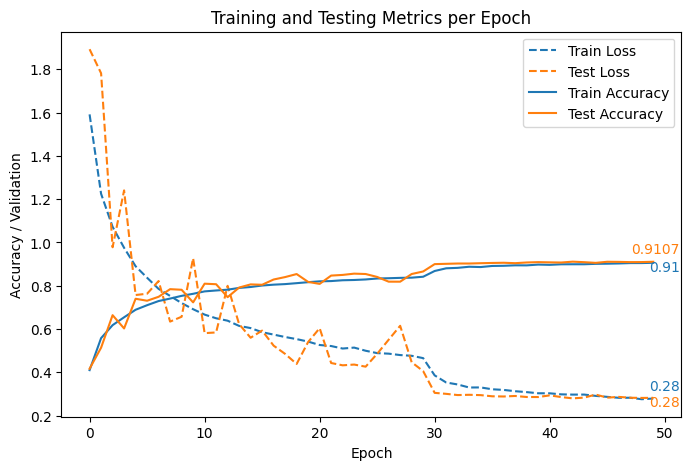

In [31]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(train_losses, label='Train Loss', color='tab:blue', linestyle='dashed')
ax.plot(test_losses, label='Test Loss', color='tab:orange', linestyle='dashed')
ax.plot(train_accuracies, label='Train Accuracy', color='tab:blue')
ax.plot(test_accuracies, label='Test Accuracy', color='tab:orange')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy / Validation')
plt.title('Training and Testing Metrics per Epoch')

offset = max(max(train_losses), max(test_losses), max(train_accuracies), max(test_accuracies)) * 0.02
adjustment = 2.3

ax.text(num_epochs - 1 + adjustment, train_losses[-1] + offset, f"{train_losses[-1]:.2f}", color='tab:blue', ha='right')
ax.text(num_epochs - 1 + adjustment, test_losses[-1] - offset, f"{test_losses[-1]:.2f}", color='tab:orange', ha='right')
ax.text(num_epochs - 1 + adjustment, train_accuracies[-1] - offset, f"{train_accuracies[-1]:.2f}", color='tab:blue', ha='right')
ax.text(num_epochs - 1 + adjustment, test_accuracies[-1] + offset, f"{test_accuracies[-1]:.4f}", color='tab:orange', ha='right')

plt.legend()

plt.show()


# 5. Final model accuracy on CIFAR-10 Validation Set: 20%
I achieved 90% or 91% consistently with this model locally (3080ti) and on Google Collab (T4 GPU)

In [32]:
# CODE TAKEN FROM https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final model accuracy: {100 * correct / total:.4f} %")

Final model accuracy: 91.0900 %
